# Processed Data from Experiment

This is data that has been sequenced and mapped to valid combinatorial barcode combos. 
Each sequence contains a few pieces of information and roughly looks like the following:

**Spatial Barcode 1 --- Const Seq --- 5bp UMI --- S/R oligos -- 5bp UMI -- Const Seq -- Spatial Barcode 2**
* The whole sequencing read is constructed from joining two molecules together, one from one bead and another from another bead

* Spatial barcode 1 is the spatial barcode of the bead we are looking at. This was the DNA that was physcially attached to a bead. There are 96^4 possible combinations of this barcode
* Constant Sequence is a place where we can do in situ sequencing, etc... 
* S/R oligos are the ends of the two complimentary oligos that have annealed and found each other
* Spatial barcode 2 is the spatial barcode from the diffusing molecule. It has been released on another bead and found its way over to this bead
* the Two 5 base UMIs are joined and treated as a single 10 base UMI.
* Reads are collapsed if they have the same 10 base UMI, the same S/R sequence and the same spatial barcodes. 



In [2]:
import requests

def download_save_data(link, path):
    """
    Download and save data from link to path
    :param link: link to download data
    :param path: path to save data
    :return: None
    """
    with open(path, 'wb') as f:
        response = requests.get(link)
        f.write(response.content)

In [3]:
# Download the nextera_interactions.txt file
download_save_data('https://www.dropbox.com/s/fqgdelppxp3fedz/nextera_interactions.txt?dl=1', 'nextera_interactions.txt')

# Download the Nextera nextera_interactions.txt file
download_save_data('https://www.dropbox.com/scl/fi/zcoi39sp65fqyps31flaf/count.matrix.filtered.MM?rlkey=lqtrsszkcm922e6fn43gwtkhr&dl=1', 'count.matrix.filtered.MM')


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO
from scipy.sparse import coo_matrix

In [5]:
# Read a sparse matrix file into a pandas dataframe
def create_sparse_matrix_from_file(file_path):
    try:
        # Read data from CSV file
        df = pd.read_csv(file_path)
        
        # Convert columns to integers
        df[['R1_bc', 'R2_bc', 'count']] = df[['R1_bc', 'R2_bc', 'count']].astype(int)
        
        # Extract row indices, column indices, and values
        row_indices = df['R1_bc'].to_numpy()
        col_indices = df['R2_bc'].to_numpy()
        values = df['count'].to_numpy()
        
        # Determine the shape of the matrix
        nrows = row_indices.max() + 1
        ncols = col_indices.max() + 1
        
        # Create and return the sparse matrix
        return coo_matrix((values, (row_indices, col_indices)), shape=(nrows, ncols))
    
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [6]:
file_path = "nextera_interactions.txt"
sparse_matrix_all_interactions = create_sparse_matrix_from_file(file_path)

# Plot the number of unique interactions per bead (R1 and R2)

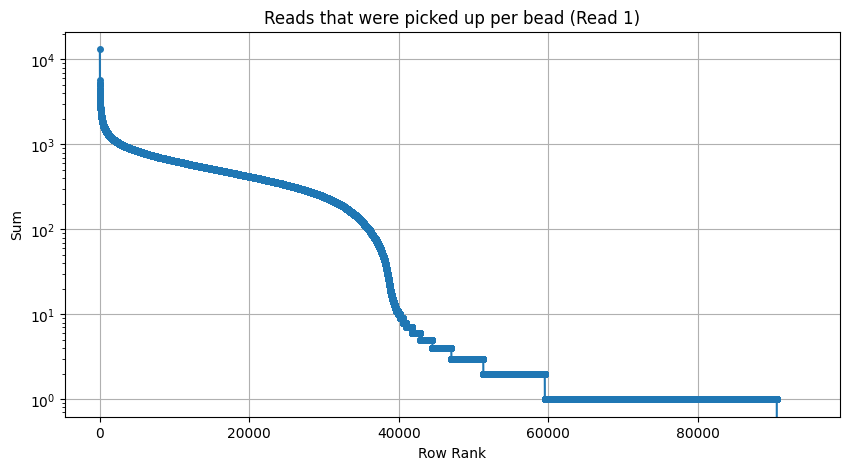

In [7]:
# Sum the rows
row_sums = np.array(sparse_matrix_all_interactions.sum(axis=1)).flatten()

# Sort the sums in descending order
sorted_sums = np.sort(row_sums)[::-1]

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(sorted_sums, marker='o', linestyle='-', markersize=4)
plt.title('Reads that were picked up per bead (Read 1)')
plt.xlabel('Row Rank')
plt.ylabel('Sum')
plt.yscale('log')
plt.grid(True)
plt.show()

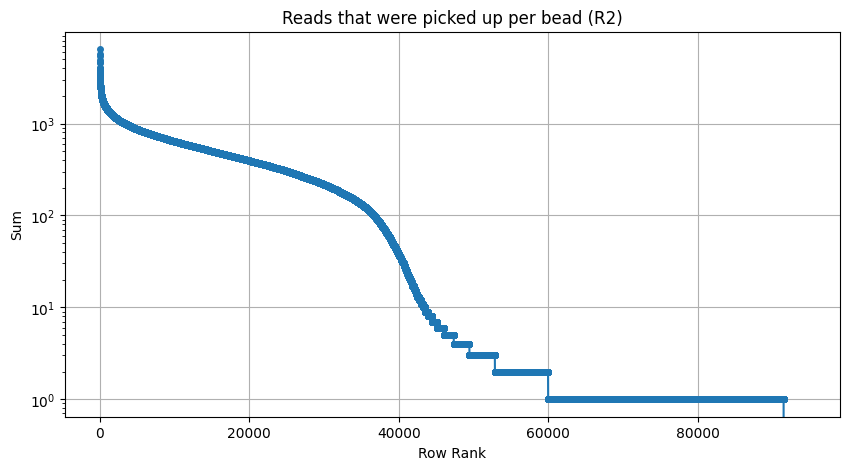

In [8]:
# Sum the columns
col_sums = np.array(sparse_matrix_all_interactions.sum(axis=0)).flatten()

# Sort the sums in descending order
sorted_sums = np.sort(col_sums)[::-1]

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(sorted_sums, marker='o', linestyle='-', markersize=4)
plt.title('Reads that were picked up per bead (R2)')
plt.xlabel('Row Rank')
plt.ylabel('Sum')
plt.yscale('log')
plt.grid(True)
plt.show()


# What's going on here?
This is called a knee plot by single cell folks. We have sequenced these beads in bulk and we have no idea which of the beads are on our array. There is a space of 94 <sup>4</sup> possible barcode combinations. We think that there were roughly 40K beads in this experiment (based on microscopy data). To get real beads we set some cutoff and say that a bead 

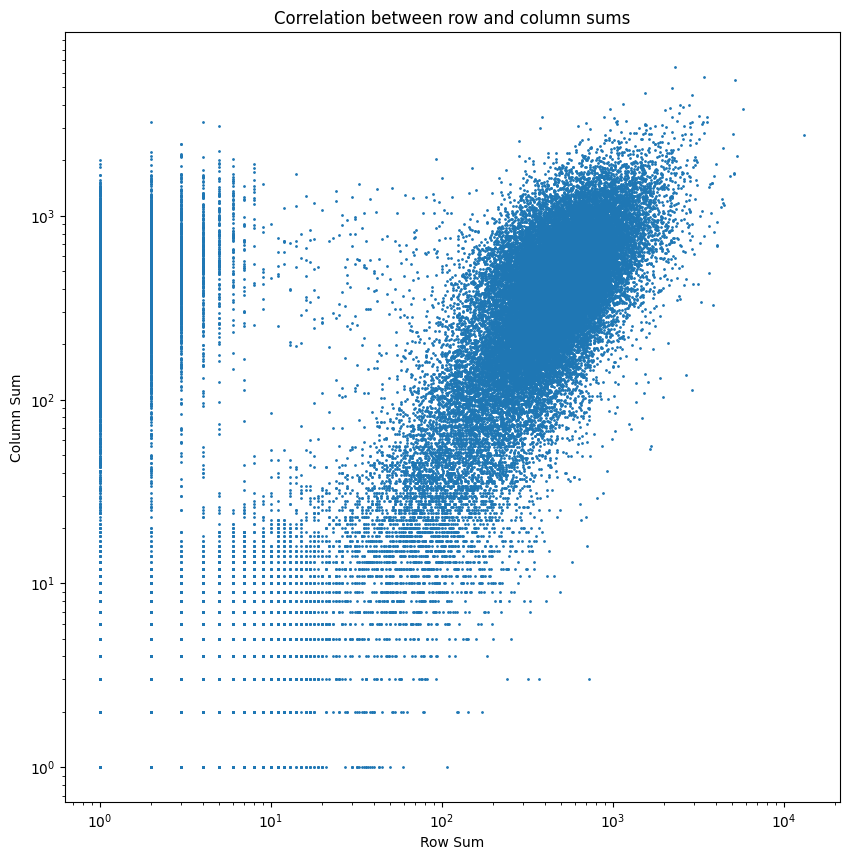

In [13]:
df_row_col_corr = pd.DataFrame({'row_sums': row_sums, 'col_sums': col_sums})
plt.figure(figsize=(10, 10))
plt.title('Correlation between row and column sums')
plt.xlabel('Row Sum')
plt.ylabel('Column Sum')
plt.scatter(row_sums, col_sums, s=1)
plt.yscale('log')
plt.xscale('log')
plt.show()
